In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [19]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211108-100x-reuseevq-pyopt"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[3].replace("nodes","")
    chunks = timedir.split("_")[2].replace("chunks","")
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,20.425,18330941352,385,7058797416,3,1,16
1,20.577,18567434891,380,7058797416,7,1,16
2,20.524,18462155059,382,7058797416,7,1,16
3,19.553,18449813088,382,7058797416,7,1,16
4,19.980,18722943863,377,7058797416,7,1,16
...,...,...,...,...,...,...,...
4027,4.158,3621209803,278,1008399612,7,7,112
4028,4.375,3787970048,266,1008399612,7,7,112
4029,4.366,3545934975,284,1008399612,7,7,112
4030,4.100,3429370980,294,1008399744,77,7,112


In [20]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput

,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,16,19.886437,1.846687e+10,381.868056,7.058797e+09,7.5,1.0
1,32,11.992382,1.141109e+10,309.312500,3.529399e+09,15.5,2.0
2,48,8.764009,8.229386e+09,286.108796,2.352932e+09,23.5,3.0
3,64,6.836429,6.310078e+09,279.682292,1.764699e+09,31.5,4.0
4,80,5.717790,5.169533e+09,273.579167,1.411759e+09,39.5,5.0
5,96,4.967060,4.370831e+09,269.719907,1.176466e+09,47.5,6.0
6,112,4.162538,3.526532e+09,285.967262,1.008400e+09,55.5,7.0


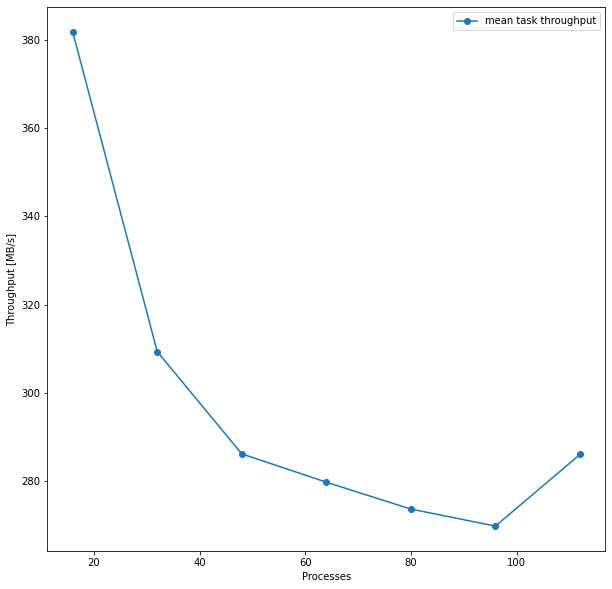

In [21]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [22]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,16,1,120,318.183000,2.954700e+11,6109.888889,1.129408e+11,5.966688
1,32,2,496,383.756222,3.651547e+11,9898.000000,1.129408e+11,9.666016
2,48,3,1128,420.672444,3.950105e+11,13733.222222,1.129408e+11,13.411350
3,64,4,2016,437.531444,4.038450e+11,17899.666667,1.129408e+11,17.480143
4,80,5,3160,457.423222,4.135627e+11,21886.333333,1.129408e+11,21.373372
5,96,6,4560,476.837778,4.195998e+11,25893.111111,1.129408e+11,25.286241
6,112,7,6216,466.204222,3.949716e+11,32028.333333,1.129408e+11,31.277669


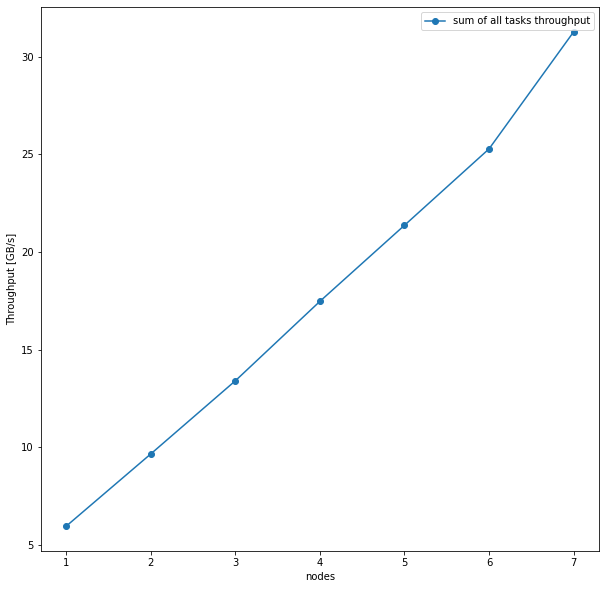

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="sum of all tasks throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

# Python timer

In [7]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211108-100x-reuseevq-pyopt/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = readpercent * datasetsize

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes.csv","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/1024/1024))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_MB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_MB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,20.71,0.08,5762,1.000000,1.000000
1,2,12.69,0.12,9401,1.631994,1.631552
2,3,9.47,0.22,12604,2.186906,2.187435
3,4,7.41,0.07,16112,2.794872,2.796251
4,5,6.26,0.10,19053,3.308307,3.306664
5,6,5.54,0.08,21557,3.738267,3.741236
6,7,4.69,0.04,25426,4.415778,4.412704


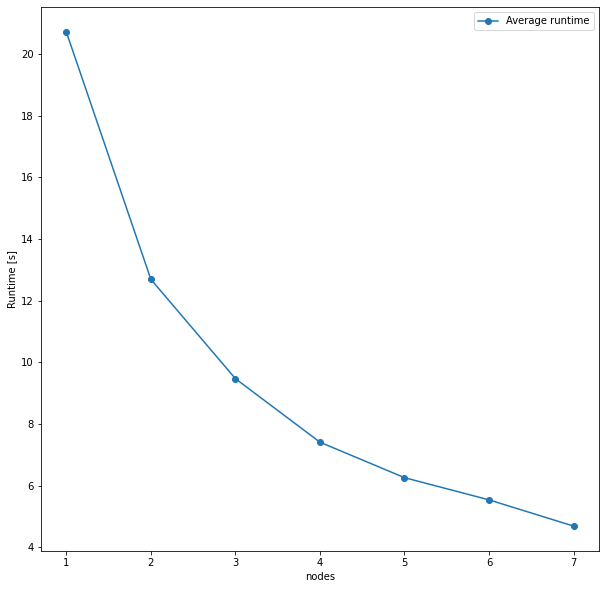

In [34]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

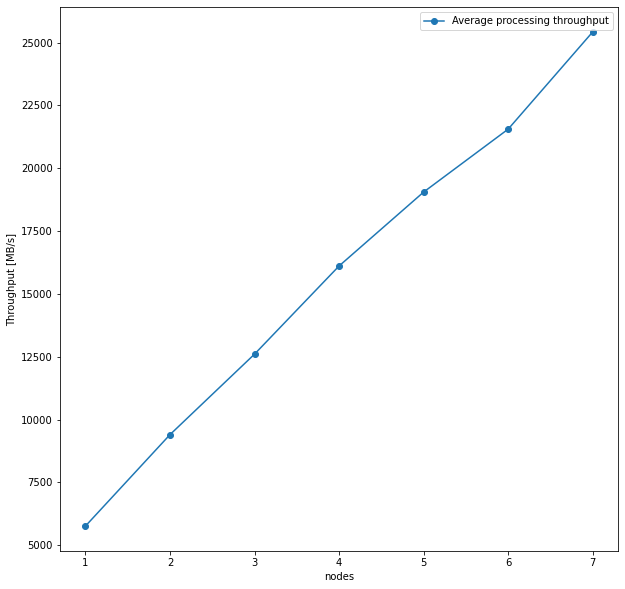

In [35]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

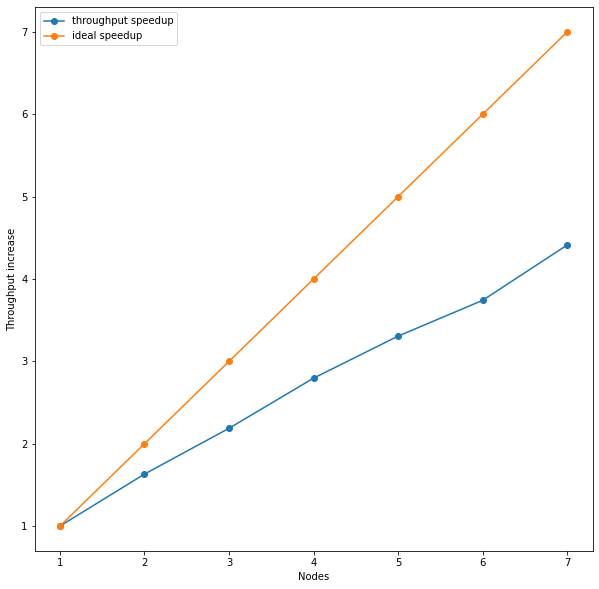

In [36]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()

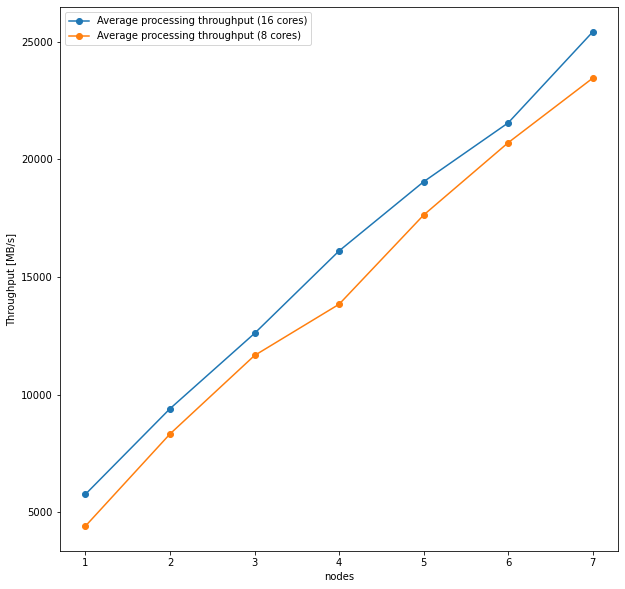

In [63]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput (16 cores)", marker="o")
pyplot.plot(timesdf_8["nodes"], timesdf_8["throughput_MB_s"], label="Average processing throughput (8 cores)", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

# Comparison 8 vs 16 cores per node

In [81]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211108-100x-reuseevq-pyopt-8corespernode/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = readpercent * datasetsize

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/1024/1024))
    
timesdf_8 = pandas.DataFrame(times)
timesdf_8 = timesdf_8.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf_8["throughput_MB_s"][0]
time_1node = timesdf_8["meanruntime"][0]
timesdf_8["runtimespeedup"] = time_1node / timesdf_8["meanruntime"]
timesdf_8["throughputspeedup"] = timesdf_8["throughput_MB_s"] / throughput_1node
timesdf_8

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,27.07,0.34,4408,1.000000,1.000000
1,2,14.33,0.23,8326,1.889044,1.888838
2,3,10.23,0.15,11664,2.646139,2.646098
3,4,8.62,0.25,13843,3.140371,3.140426
4,5,6.77,0.09,17637,3.998523,4.001134
5,6,5.76,0.07,20714,4.699653,4.699183
6,7,5.09,0.06,23459,5.318271,5.321915


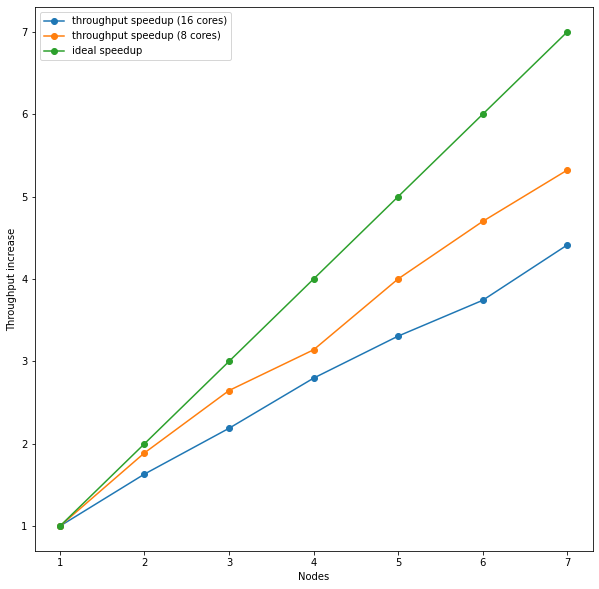

In [82]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup (16 cores)", marker="o")
pyplot.plot(timesdf_8["nodes"], timesdf_8["throughputspeedup"], label="throughput speedup (8 cores)", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()

In [17]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211108-100x-reuseevq-pyopt-8corespernode"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[3].replace("nodes","")
    chunks = timedir.split("_")[2].replace("chunks","")
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,23.848,9090828605,1552,14117594700,2,1,8
1,23.843,8549129583,1651,14117594700,4,1,8
2,23.669,7888680725,1789,14117594700,4,1,8
3,24.042,9723486580,1451,14117594700,4,1,8
4,22.165,8497557454,1661,14117594700,4,1,8
...,...,...,...,...,...,...,...
2011,4.723,4122189865,489,2016799224,22,7,56
2012,4.599,3730529697,540,2016799224,22,7,56
2013,5.120,4378851412,460,2016799224,22,7,56
2014,4.418,3543774452,569,2016799224,18,7,56


In [18]:
sumthroughput_8cores = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput_8cores = sumthroughput_8cores.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput_8cores = sumthroughput_8cores.reset_index()
sumthroughput_8cores["totalthroughput"] = sumthroughput_8cores["readthroughput"] / 1024
sumthroughput_8cores

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,8,1,28,195.745889,7.648605e+10,12378.000000,1.129408e+11,12.087891
1,16,2,120,209.015667,1.267813e+11,14864.666667,1.129408e+11,14.516276
2,24,3,276,225.428111,1.816030e+11,15063.000000,1.129408e+11,14.709961
3,32,4,496,242.242556,2.078966e+11,17545.555556,1.129408e+11,17.134332
4,40,5,780,246.018333,2.096400e+11,21714.555556,1.129408e+11,21.205621
5,48,6,1128,248.029222,2.075292e+11,26251.444444,1.129408e+11,25.636176
6,56,7,1540,256.585444,2.136318e+11,29746.555556,1.129408e+11,29.049371


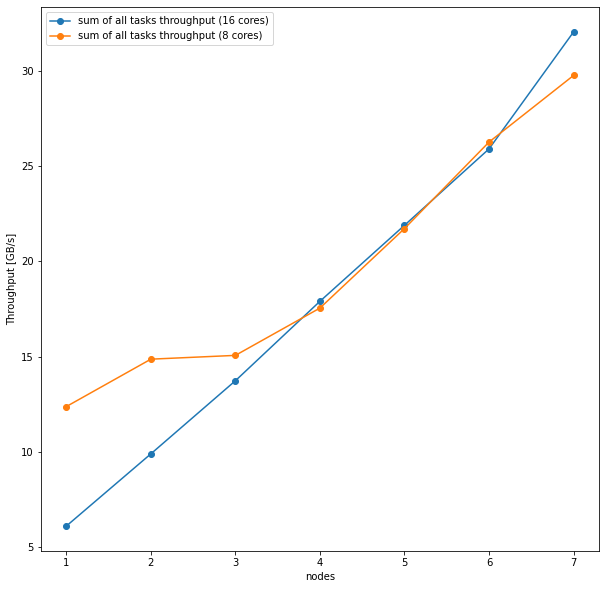

In [24]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["readthroughput"]/1000, label="sum of all tasks throughput (16 cores)", marker="o")
pyplot.plot(sumthroughput_8cores["nodes"], sumthroughput_8cores["readthroughput"]/1000, label="sum of all tasks throughput (8 cores)", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughputspeedup.png has been created


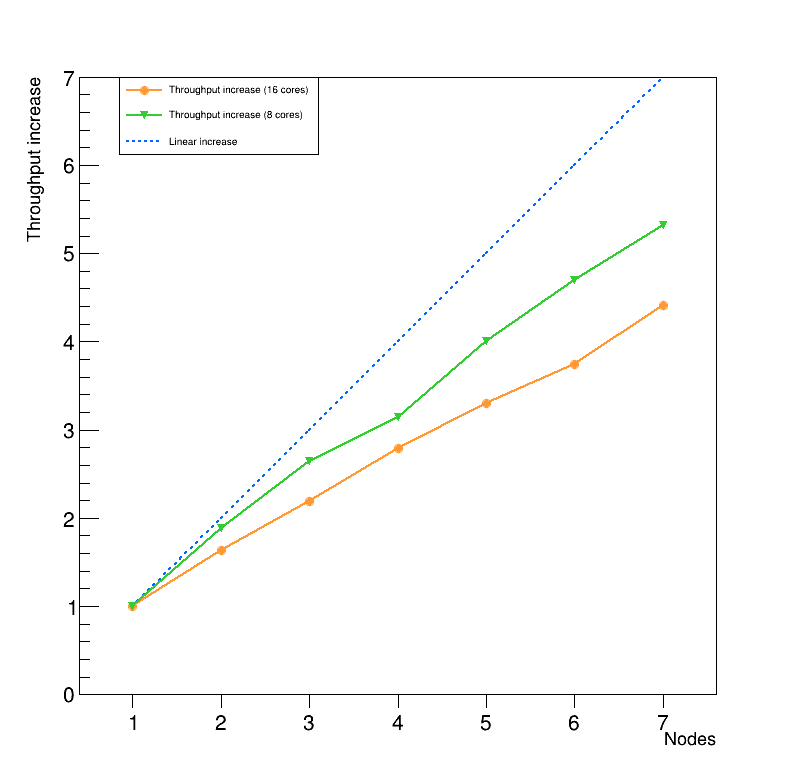

In [83]:
speedupgraph_16 = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
speedupgraph_8 = ROOT.TGraph(len(timesdf_8["nodes"]), numpy.array(timesdf_8["nodes"], dtype=float), numpy.array(timesdf_8["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["nodes"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 7)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.4, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph_16.SetMarkerStyle(20)
speedupgraph_16.SetMarkerSize(1)
speedupgraph_16.SetMarkerColor(ROOT.kOrange+1)


speedupgraph_16.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph_16.SetLineWidth(2)

speedupgraph_16.Draw("SAME PL")

speedupgraph_8.SetMarkerStyle(23)
speedupgraph_8.SetMarkerSize(1)
speedupgraph_8.SetMarkerColor(ROOT.kGreen-3)


speedupgraph_8.SetLineColorAlpha(ROOT.kGreen-3,1)
speedupgraph_8.SetLineWidth(2)

speedupgraph_8.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph_16, "Throughput increase (16 cores)")
legend.AddEntry(speedupgraph_8, "Throughput increase (8 cores)")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughputcomparison.png has been created


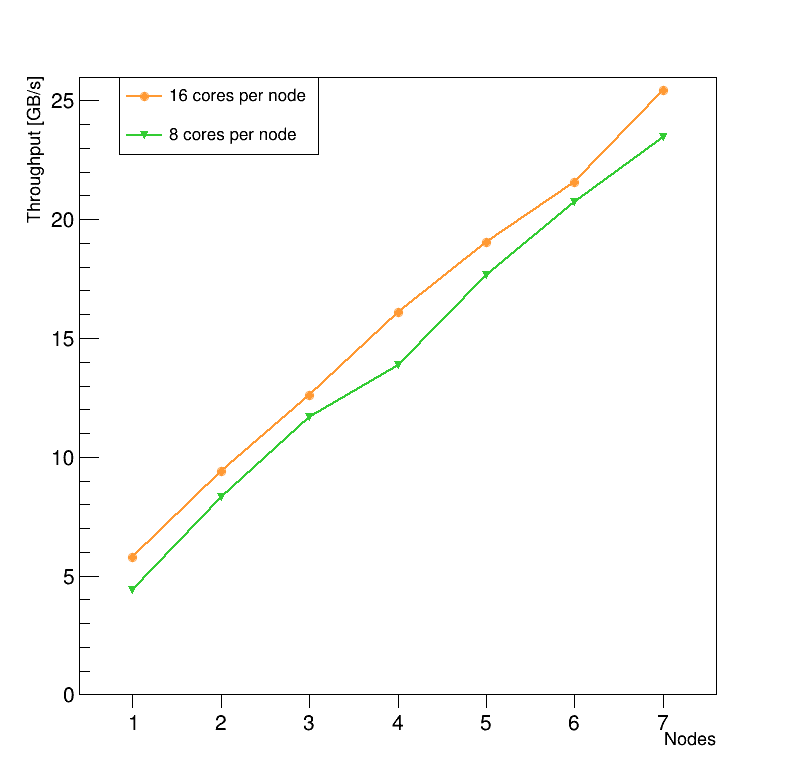

In [84]:
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughput_MB_s"]/1000, dtype=float))
speedupgraph_8 = ROOT.TGraph(len(timesdf_8["nodes"]), numpy.array(timesdf_8["nodes"], dtype=float), numpy.array(timesdf_8["throughput_MB_s"]/1000, dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput [GB/s]")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 26)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)


idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetMarkerColor(ROOT.kOrange+1)

idealspeedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("APL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -1.5, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)


speedupgraph_8.SetMarkerStyle(23)
speedupgraph_8.SetMarkerSize(1)
speedupgraph_8.SetMarkerColor(ROOT.kGreen-3)


speedupgraph_8.SetLineColorAlpha(ROOT.kGreen-3,1)
speedupgraph_8.SetLineWidth(2)

speedupgraph_8.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(idealspeedupgraph, "16 cores per node")
legend.AddEntry(speedupgraph_8, "8 cores per node")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputcomparison.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_readthroughputcomparison.png has been created


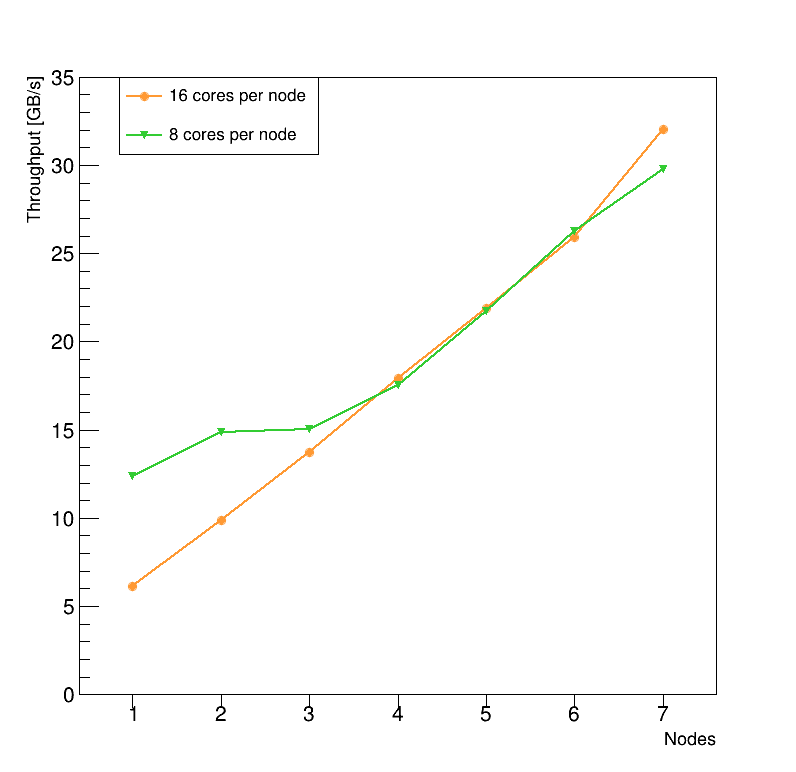

In [28]:
idealspeedupgraph = ROOT.TGraph(len(sumthroughput["nodes"]), numpy.array(sumthroughput["nodes"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))
speedupgraph_8 = ROOT.TGraph(len(sumthroughput_8cores["nodes"]), numpy.array(sumthroughput_8cores["nodes"], dtype=float), numpy.array(sumthroughput_8cores["readthroughput"]/1000, dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput [GB/s]")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 35)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)


idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetMarkerColor(ROOT.kOrange+1)

idealspeedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("APL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(sumthroughput["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -1.5, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)


speedupgraph_8.SetMarkerStyle(23)
speedupgraph_8.SetMarkerSize(1)
speedupgraph_8.SetMarkerColor(ROOT.kGreen-3)


speedupgraph_8.SetLineColorAlpha(ROOT.kGreen-3,1)
speedupgraph_8.SetLineWidth(2)

speedupgraph_8.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(idealspeedupgraph, "16 cores per node")
legend.AddEntry(speedupgraph_8, "8 cores per node")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_multinode_readthroughputcomparison.png")